In [2]:
import os
import re
import zipfile
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time
from time import time
from tqdm import tqdm
from pycocotools.coco import COCO
from PIL import Image
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
from skimage.io import imread
from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

import torch
import cv2
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import torchvision
from skimage.transform import resize
from torchvision.transforms import v2 as T
from torchsummary import summary
from torchvision.utils import save_image

from matplotlib import pyplot as plt
from torchvision.io import read_image, ImageReadMode

from torchvision.models import resnet50, ResNet50_Weights, densenet121, DenseNet121_Weights
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc


from torchvision.models.detection.ssd import SSDClassificationHead
from torchvision.models.detection import _utils
from torchvision.models.detection import SSD300_VGG16_Weights
from torchvision.ops import box_iou, complete_box_iou, complete_box_iou_loss

%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)
plt.ion()


In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [5]:
BATCH_SIZE = 64
IMG_SIZE = 224
IMG_SIZE_D = 320
generator = torch.Generator().manual_seed(1001)

In [6]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Путь к папке с данными
dataDir = '/content/drive/MyDrive/XX/train'


# Применяем трансформации с учетом преобразования в RGB
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Приводим все изображения к размеру 224x224
    transforms.Lambda(lambda image: image.convert('RGB')),  # Преобразование в RGB
    transforms.ToTensor(),  # Преобразуем в тензор
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Нормализация
])


In [8]:
# Загрузка данных
image_datasets = datasets.ImageFolder(os.path.join(dataDir), data_transforms)
dataloaders = {
    'train': DataLoader(image_datasets, batch_size=32, shuffle=True)
}

In [9]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomInvert()
    ])

In [10]:
class Document(torch.utils.data.Dataset):
    def __init__(self, root, label, transform):
        self.root = root
        self.label = label
        self.transforms = transform
        self.imgs = os.listdir(os.path.join(self.root, self.label))

    def __getitem__(self, idx):
        # load images and labels
        img_path = os.path.join(self.root, self.label, self.imgs[idx])
        img = Image.open(img_path).convert('RGB')
        target = CLASSES[self.label]

        return self.transforms(img), torch.tensor(target), self.label

    def __len__(self):
        return len(self.imgs)

In [11]:
folders = ['1', '2', '3', '4']
CLASSES = {'1': 0,
           '2': 1,
           '3': 2,
           '4':3
}

In [13]:
data_1 = Document(dataDir, folders[0], transformer)
data_2 = Document(dataDir, folders[1], transformer)
data_3 = Document(dataDir, folders[2], transformer)
data_4 = Document(dataDir, folders[3], transformer)
print(f'classes size: \n {folders[0]} -- {len(data_1)} \n {folders[1]} -- {len(data_2)} \n {folders[2]} -- {len(data_3)} \n {folders[3]} -- {len(data_4)} \n')
data_brain = ConcatDataset([data_1, data_2, data_3, data_4])
train, valid, test = torch.utils.data.random_split(data_brain, [.6, .2, .2], generator=generator)
print(f"train - {len(train)} \n valid - {len(valid)} \n test - {len(test)}")


classes size: 
 1 -- 173 
 2 -- 173 
 3 -- 173 
 4 -- 173 

train - 416 
 valid - 138 
 test - 138


In [14]:
train_dataloader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_dataloader = torch.utils.data.DataLoader(valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
batch = next(iter(train_dataloader))

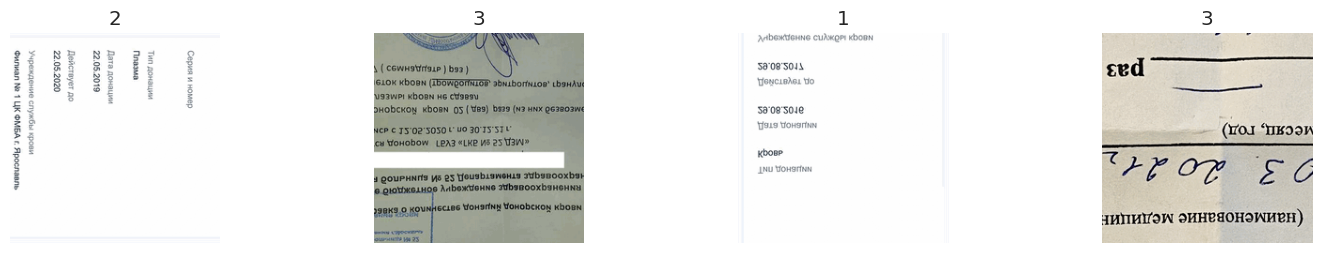

In [15]:
look = next(iter(train_dataloader))
plt.figure(figsize=(18, 6))
for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.axis("off")
    plt.imshow(look[0][i].permute(1,2,0))
    plt.title(look[2
                  ][i])
plt.show();

In [16]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels, _ in train_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [18]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels, _ in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size
    return val_loss, val_acc

In [21]:
def predict(model, test_loader):
    running_corrects = 0
    processed_size = 0
    with torch.no_grad():
        logits = []
        preds = []
        answers = []

        for inputs, labels, _ in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            model.eval()
            outputs = model(inputs)
            logits.append(outputs.cpu())
            preds.append(torch.argmax(outputs, 1).cpu())
            answers.append(labels.cpu())
            running_corrects += torch.sum(torch.argmax(outputs, 1) == labels.data)
            processed_size += inputs.size(0)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    preds = torch.cat(preds, dim=-1).numpy()
    answers = torch.cat(answers, dim=-1).numpy()
    test_acc = running_corrects.cpu().numpy() / processed_size
    return answers, preds, probs, test_acc

In [22]:
def train(train, val, model, epochs, rate, criterion):

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=rate)
        sch = lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train, criterion, opt, sch)

            val_loss, val_acc = eval_epoch(model, val, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [23]:
def vizualize(h, model):
    loss, acc, val_loss, val_acc = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(model)
    plt.show()
    plt.plot(acc, label="train_accuracy")
    plt.plot(val_acc, label="validation_accuracy")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.title(model)
    plt.show()

In [ ]:
model = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 153MB/s]


## Pretrained Models


In [ ]:
# Функция потерь (кросс-энтропия, так как это задача классификации)
criterion = nn.CrossEntropyLoss()

# Оптимизатор (Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)


ResNet_50

In [26]:
weights = ResNet50_Weights.DEFAULT
resnet = resnet50(weights=weights)

# Set requires_grad = False for all parameters
for param in resnet.parameters():
    param.requires_grad = False

# Re-enable requires_grad for the last 3 layers
layers = list(resnet.children())
for layer in layers[-4:]:
    for param in layer.parameters():
        param.requires_grad = True
in_features = 2048
out_features = 4
resnet.fc = nn.Linear(in_features, out_features)
resnet = resnet.to(device)

In [ ]:
out = resnet(torch.rand(64, 3, 224, 224).to(device))

In [ ]:
out[0]

tensor([-0.0218,  0.0523,  0.1075,  0.0131], device='cuda:0',
       grad_fn=<SelectBackward0>)

RotNet

In [ ]:
# Определение RotNet на основе ResNet
class RotNet(nn.Module):
    def __init__(self):
        super(RotNet, self).__init__()
        # Используем предобученную ResNet-18
        self.model = models.resnet18(pretrained=True)
        num_ftrs = self.model.fc.in_features
        # Заменяем последний полносвязный слой, чтобы было 4 класса (для углов поворота)
        self.model.fc = nn.Linear(num_ftrs, 4)  # 4 класса (0°, 90°, 180°, 270°)

    def forward(self, x):
        return self.model(x)

# Инициализация модели
model = RotNet()

# Используем устройство CUDA (если доступно)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]


TRAINING

In [30]:
ce = nn.CrossEntropyLoss()
lr = 3e-4

In [31]:
history = train(train_dataloader, valid_dataloader, model=resnet, epochs=10, rate=lr, criterion=ce)

epoch:  10%|█         | 1/10 [02:52<25:50, 172.27s/it]


Epoch 001 train_loss: 1.2860     val_loss 1.1989 train_acc 0.3462 val_acc 0.3841


epoch:  20%|██        | 2/10 [03:08<10:43, 80.38s/it]


Epoch 002 train_loss: 0.9279     val_loss 0.8720 train_acc 0.5625 val_acc 0.3841


epoch:  30%|███       | 3/10 [03:23<05:54, 50.67s/it]


Epoch 003 train_loss: 0.7786     val_loss 0.8214 train_acc 0.5649 val_acc 0.4565


epoch:  40%|████      | 4/10 [03:39<03:40, 36.82s/it]


Epoch 004 train_loss: 0.7496     val_loss 0.8508 train_acc 0.5769 val_acc 0.3696


epoch:  50%|█████     | 5/10 [03:55<02:26, 29.26s/it]


Epoch 005 train_loss: 0.7040     val_loss 0.8650 train_acc 0.5865 val_acc 0.3478


epoch:  60%|██████    | 6/10 [04:11<01:39, 24.78s/it]


Epoch 006 train_loss: 0.6843     val_loss 0.8948 train_acc 0.6346 val_acc 0.3333


epoch:  70%|███████   | 7/10 [04:27<01:06, 22.16s/it]


Epoch 007 train_loss: 0.6683     val_loss 0.9017 train_acc 0.6370 val_acc 0.3188


epoch:  80%|████████  | 8/10 [04:43<00:39, 19.97s/it]


Epoch 008 train_loss: 0.6400     val_loss 0.8941 train_acc 0.6731 val_acc 0.3478


epoch:  90%|█████████ | 9/10 [04:59<00:18, 18.66s/it]


Epoch 009 train_loss: 0.6228     val_loss 0.9358 train_acc 0.6827 val_acc 0.2971


epoch: 100%|██████████| 10/10 [05:14<00:00, 31.44s/it]


Epoch 010 train_loss: 0.6279     val_loss 0.9622 train_acc 0.6971 val_acc 0.2681


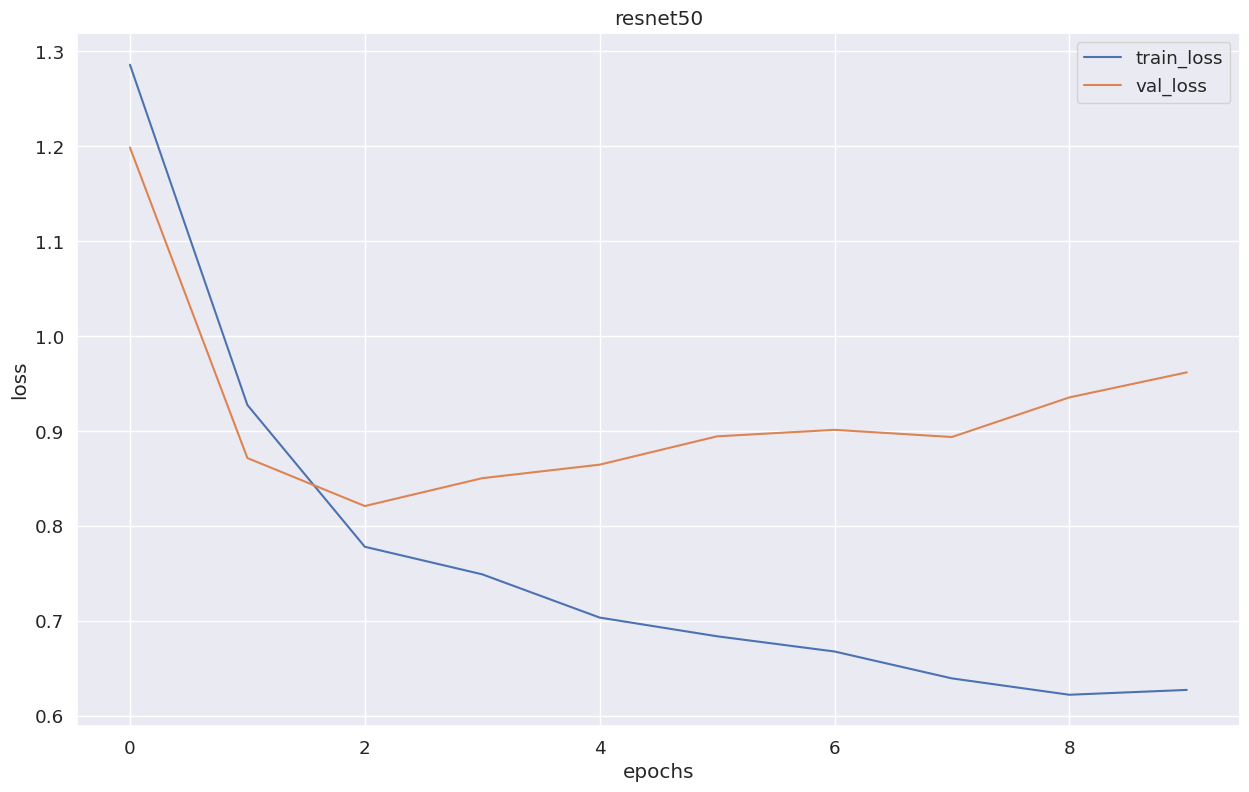

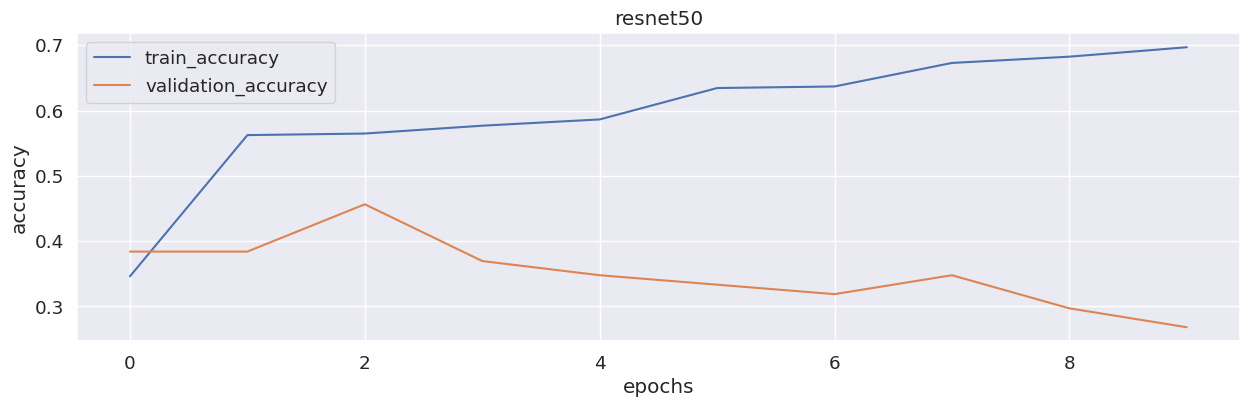

In [33]:
vizualize(history, 'resnet50')

In [46]:
# based on RotNet Implementaion: https://github.com/d4nst/RotNet

class RotNet(nn.Module):
    def __init__(self, num_classes=4, num_channels=3, in_channels=3, has_dropout=True, dropout_rate=0.25):
        super(RotNet, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes

        # Residual Blocks
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3))
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3))
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3))
        self.max_pool = nn.MaxPool2d((2, 2))

        # MLP
        self.fc_1 = nn.Linear(12544, 128)
        self.fc_2 = nn.Linear(128, self.num_classes)

        self.ReLU = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.ReLU(x)
        x = self.max_pool(x)
        x = self.conv2(x)
        x = self.ReLU(x)
        x = self.max_pool(x)
        x = self.conv3(x)
        x = self.ReLU(x)
        x = self.max_pool(x)
        x = self.dropout(x)

        x = x.view(x.shape[0], -1)
        x = self.fc_1(x)
        x = self.ReLU(x)
        x = self.dropout(x)

        x = self.fc_2(x)
        x = self.softmax(x)
        return x

In [47]:
model_RN = RotNet(num_classes=11, has_dropout=True)
model.to('cuda')


RotNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (max_pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=12544, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=11, bias=True)
  (ReLU): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (softmax): Softmax(dim=1)
)

In [49]:

random_input = torch.rand((3, 3, 128, 128)).to('cuda')
output = model(random_input)
output, torch.sum(output)

(tensor([[0.0872, 0.0892, 0.0847, 0.0962, 0.0963, 0.0833, 0.0949, 0.0884, 0.0898,
          0.0922, 0.0980],
         [0.0863, 0.0877, 0.0856, 0.0982, 0.0942, 0.0828, 0.0935, 0.0910, 0.0892,
          0.0932, 0.0983],
         [0.0878, 0.0900, 0.0844, 0.0957, 0.0920, 0.0853, 0.0935, 0.0911, 0.0884,
          0.0949, 0.0970]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor(3., device='cuda:0', grad_fn=<SumBackward0>))

In [50]:
history = train(train_dataloader, valid_dataloader, model=model_RN, epochs=10, rate=lr, criterion=ce)

epoch:   0%|          | 0/10 [00:01<?, ?it/s]


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same